# Financial Econometrics Project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from numpy import size, log, pi, sum, array, zeros, diag, mat, asarray, sqrt, \
    copy
from numpy.linalg import inv
from scipy.optimize import fmin_slsqp

#Set figure space
import statsmodels.api as sm
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})

In [2]:
data_daily = pd.read_csv('data_daily', index_col = [0], parse_dates = ['date'])

In [3]:
df_daily = data_daily.copy()

In [4]:
data = pd.read_csv('data_monthly.csv',index_col=[0],parse_dates=['date'])
Rm = pd.read_csv('Rm.csv',index_col=[0],parse_dates=['date'])
Rmd = pd.read_csv('Rm_daily.csv',index_col=[0],parse_dates=['date'])
Rf = pd.read_csv('Rf.csv',index_col=[0],parse_dates=['date'])

Build momentum strategy using market cap weighted approach:

Cumulative 12 month past return for each stock:

In [5]:
data['Log_Rn'] = np.log(data['Rn'] + 1)
data['cum_log_Rn'] = data.groupby('permno')['Log_Rn'].rolling(11).sum().droplevel(0)
#data = data.dropna(subset='cum_log_Rn')
data['cum_log_Rn_fw2']= data.groupby('permno')['cum_log_Rn'].shift(2)
#data = data.dropna(subset='cum_log_Rn_fw2')

Add column with number of observation in the last year for each stock

In [6]:
data['rollingcount']=(data.groupby('permno')['date'].rolling(12).count()).droplevel(0)

Momentum Decile Weights (market-cap weighted)

In [7]:
data['deciles']=data[data.rollingcount>8].dropna(subset = ['cum_log_Rn_fw2']).groupby('date').apply(lambda x: pd.qcut(x['cum_log_Rn_fw2'], q=10, labels=[1,2,3,4,5,6,7,8,9,10])).droplevel(0)

In [8]:
data['w_h']=data.loc[data.deciles==10]['mcap_l']/data.loc[data.deciles==10].groupby('date')['mcap_l'].transform('sum')
data['w_h']=data['w_h'].fillna(0)

data['w_l']=data.loc[data.deciles==1]['mcap_l']/data.loc[data.deciles==1].groupby('date')['mcap_l'].transform('sum')
data['w_l']=data['w_l'].fillna(0)

data['w_mom'] = data['w_h']-data['w_l']

Add momentum weights to daily data

In [9]:
data['month_year'] = data['date'].dt.to_period('M')
df_daily['month_year'] = df_daily['date'].dt.to_period('M')

In [10]:
df_daily = pd.merge(df_daily,data[['month_year','w_mom','permno']],on = ['month_year','permno'],how = 'left')

Compute daily momentum returns and realized variance

In [11]:
df_daily['mom_ret'] = df_daily['w_mom'] * df_daily['Rn']
mom_ret_daily = df_daily.groupby('date')['mom_ret'].sum()
mom_ret_daily = mom_ret_daily.reset_index()
mom_ret_daily['month_year'] = mom_ret_daily['date'].dt.to_period('M')
monthly_mom_real_var = mom_ret_daily.groupby('month_year')['mom_ret'].var()*mom_ret_daily.groupby('month_year')['mom_ret'].count()
monthly_mom_real_var = monthly_mom_real_var.rename('monthly_mom_real_var').reset_index()

Compute Monthly Momentum Returns:

In [12]:
winners_ret = data.groupby('date').apply(lambda x: np.sum(x.Rn * x.w_h))
winners_ret_cum = (winners_ret + 1).cumprod()
losers_ret = data.groupby('date').apply(lambda x: np.sum(x.Rn * x.w_l))
losers_ret_cum = (losers_ret + 1).cumprod()
mom_ret=data.groupby('date').apply(lambda x: np.sum(x.Rn * x.w_mom))
mom_ret_cum=(mom_ret+1).cumprod()
mom_ret_cum_rf=((mom_ret + Rf.set_index('date').rf).dropna()+1).cumprod()

plt.show()

In [13]:
df = pd.DataFrame({'mom_ret':mom_ret})
df=df.merge(Rm,left_index=True,right_on='date')
df=df.merge(Rf,on='date')
df['month_year'] = df.date.dt.to_period('M')
df = df.merge(monthly_mom_real_var,on = 'month_year',how = 'inner')

Plot static Momentum Returns

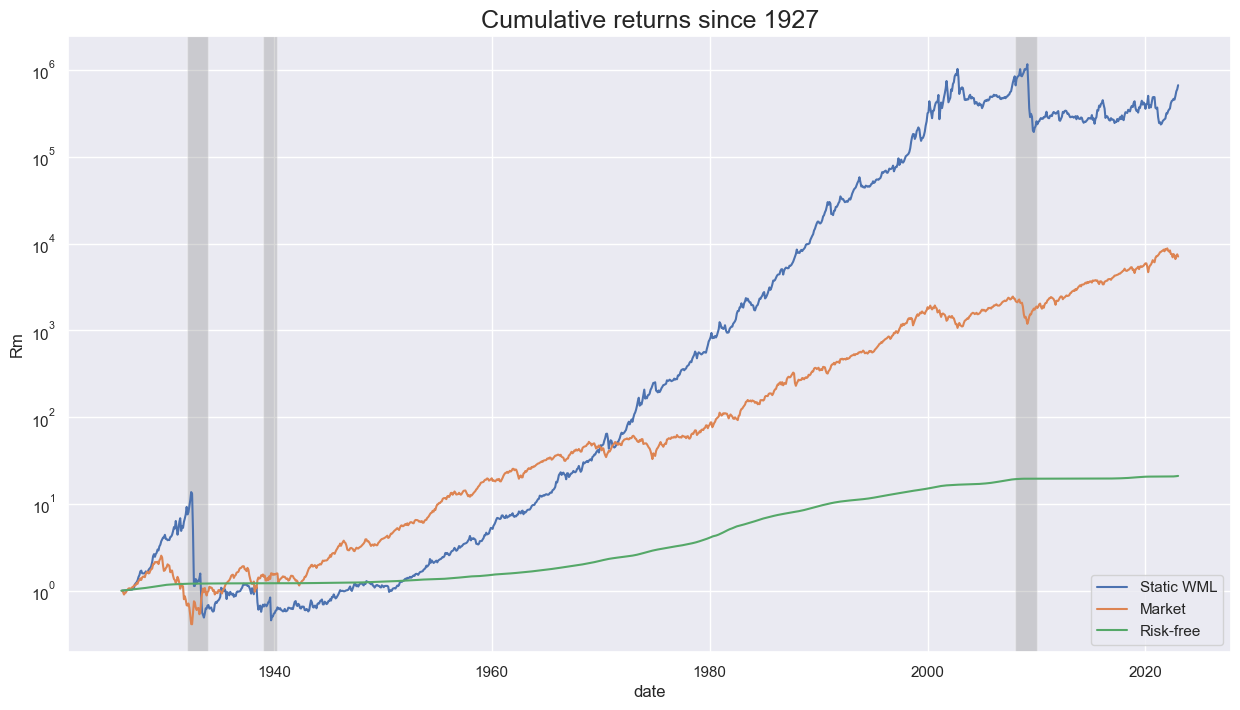

In [14]:
sns.lineplot(data=mom_ret_cum_rf, label="Static WML")
sns.lineplot(data = (1+df.set_index('date').Rm).cumprod(),label='Market')
sns.lineplot(data=(Rf.set_index('date').rf +1 ).cumprod(), label="Risk-free")
plt.yscale(value='log')
plt.title('Cumulative returns since 1927',size = 18)
plt.axvspan('1932-01-01', '1934-01-01', facecolor='grey', alpha=0.3)
plt.axvspan('1939-01-01', '1940-04-01', facecolor='grey', alpha=0.3)

plt.axvspan('2008-01-01', '2010-01-01', facecolor='grey', alpha=0.3)
plt.legend()
plt.show()

In [15]:
# Bear market indicator
df['I_b'] = ((1 + df['Rm']).rolling(24).apply(np.prod)<1).astype(int)
df['I_b'].iloc[17:23] = 0

C:\Users\loren\AppData\Local\Temp\ipykernel_14612\1367241757.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['I_b'].iloc[17:23] = 0


In [16]:
#Compute the variance for half year prior
df["s_m6"]=df["Rm"].rolling(6).var()

#Add constant to dataframe
df['const']=1

#Shift mom ret
df["Mom_ret_bw"]=df["mom_ret"].shift(-1)

In [17]:
Rmd=Rmd.set_index("date")

In [18]:
# Daily variance of previous 126 trading days (6 months)
s_d6=Rmd.rolling(126).var()
s_d6=s_d6.rename(columns={'Rmd': 'daily_126_var'})

df=df.merge(s_d6, left_on="date", right_index=True, how="left")

In [19]:
# Variance made monthly multiplying by 22 (average trading days in a month)
df['monthly_126_var'] = df['daily_126_var']*(22)
df['monthly_126_var_ann'] = df['daily_126_var']*(22)*12

In [20]:
#Add interaction term column
df["int_6"]=df["monthly_126_var_ann"]*df["I_b"]

In [21]:
# Add risk-free rate to momentum return
df['ret_mom_plu_rf'] = df['mom_ret']+Rf.rf

df["ret_mom_plu_rf_bw"]=df["ret_mom_plu_rf"].shift(-1)

Compute realized variance of daily momentum returns in the 126 days before, and make it monthly multiplying by 22.<br>
The series is shifted so that at time t we don't include the observation itself for the variance calculation.

In [22]:
mom_ret_daily['mom_var_126_M'] = mom_ret_daily.rolling(126)['mom_ret'].var().shift(1)*22
df = df.merge(mom_ret_daily.drop_duplicates('month_year')[['month_year','mom_var_126_M']],on='month_year')

Compute up- and down- betas of the momentum strategy during bear markets

In [23]:
up_returns = df[(df['Rm'] > 0)&(df['I_b']==1)]
up_model = sm.OLS(up_returns['mom_ret'], up_returns[['Rm','const']]).fit()
up_beta = up_model.params['Rm']

# Calculate the down-beta
down_returns = df[(df['Rm'] < 0)&(df['I_b']==1)]
down_model = sm.OLS(down_returns['mom_ret'], down_returns[['Rm','const']]).fit()
down_beta = down_model.params['Rm']

print("up_beta: {}, down_beta: {}".format(up_beta,down_beta))

up_beta: -1.6024417358022673, down_beta: -0.7625934177516811


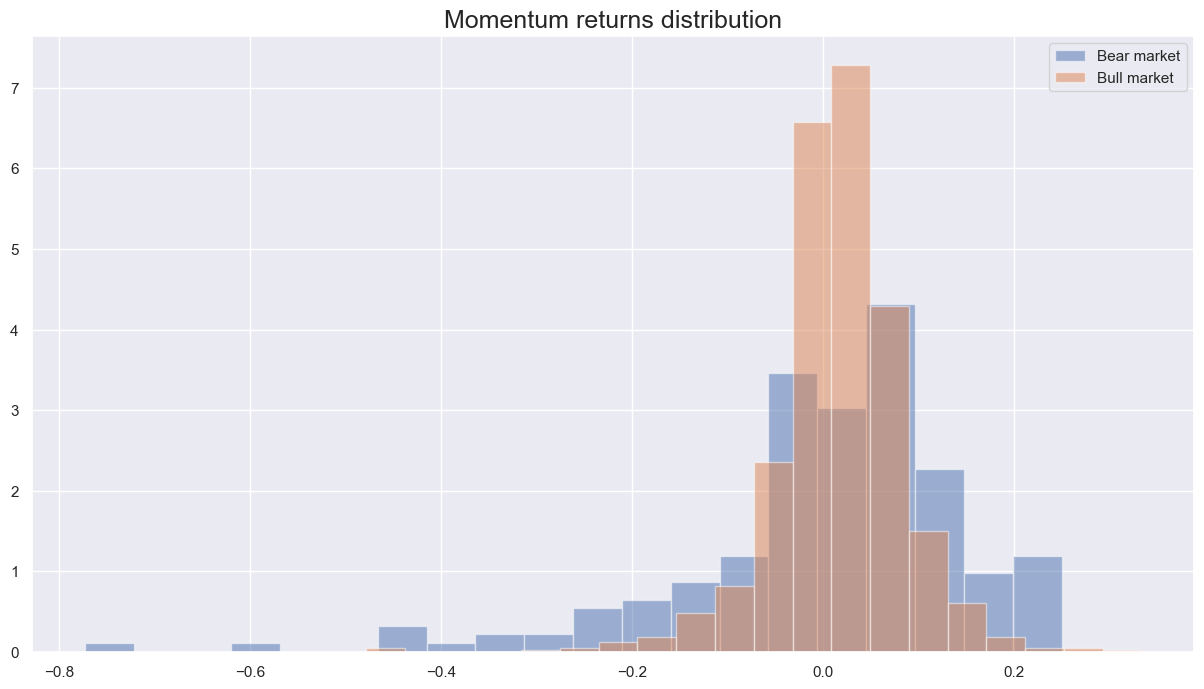

In [24]:
# Momentum returns distribution in bear markets
df[df['I_b']==True]['mom_ret'].hist(bins=20,density = True,alpha=0.5,label='Bear market')
df[df['I_b']==False]['mom_ret'].hist(bins=20,density = True,alpha=0.5,label='Bull market')
plt.legend()
plt.title('Momentum returns distribution',size=18)
plt.show()

Divide data into two dataframes for training (from 1926 to 2014) and testing (after 2014)

In [25]:
df1 = df[df.date<'2014-01-01'].copy()
df2 = df[df.date>='2014-01-01'].copy()

OLS regression of monthly momentum returns on bear market indicator, 6 previous months variance and interaction of the two factors

In [26]:
reg1=sm.OLS(df1.Mom_ret_bw.iloc[17:-1], df1[["I_b","monthly_126_var_ann", "int_6", "const"]].iloc[17:-1]).fit()

reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Mom_ret_bw   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     9.470
Date:                Sun, 11 Jun 2023   Prob (F-statistic):           3.57e-06
Time:                        21:04:49   Log-Likelihood:                 1057.3
No. Observations:                1026   AIC:                            -2107.
Df Residuals:                    1022   BIC:                            -2087.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
I_b                    -0.0010      0.010     -0.102      0.919      -0.021       0.019
monthly_126_var_ann    -0.0836      0.113     -0.739      0.460      -0.305       0.138
int_6                  -0.2660      0.145     -1.838      0.066      -0.550       0.018
const                   0.0200      0.004      5.325      0.000       0.013       0.027
==============================================================================
Omnibus:                      402.062   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4963.465
Skew:                          -1.442   Prob(JB):                         0.00
Kurtosis:                      13.382   Cond. No.                         65.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
#Predict momentum returns based on regression
df['mu']=reg1.params.const + reg1.params.I_b*df["I_b"] + reg1.params.monthly_126_var_ann*df["monthly_126_var_ann"] + reg1.params.int_6*df["int_6"]
df['mu']=df['mu'].shift(1)

In [28]:
from arch import arch_model

### GARCH models

In [29]:
# GARCH(1,1)
garch_model = arch_model(df1['mom_ret'].loc[df1['mom_ret'][df1['mom_ret'] != 0].index[0:]]
,p=1,q=1,vol='Garch',rescale=False)
garch_params=garch_model.fit(disp=False).params
garch_params

mu          0.012104
omega       0.000175
alpha[1]    0.169009
beta[1]     0.818590
Name: params, dtype: float64

In [30]:
garch_model.fit(disp=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                mom_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1281.94
Distribution:                  Normal   AIC:                          -2555.89
Method:            Maximum Likelihood   BIC:                          -2536.13
                                        No. Observations:                 1032
Date:                Sun, Jun 11 2023   Df Residuals:                     1031
Time:                        21:04:51   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0121  1.947e-03      6.218  5.027e-10 [8.289e-03,1.592e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.7518e-04  1.134e-04      1.545      0.122 [-4.705e-05,3.974e-04]
alpha[1]       0.1690  5.128e-02      3.296  9.821e-04    [6.850e-02,  0.270]
beta[1]        0.8186  6.058e-02     13.513  1.307e-41      [  0.700,  0.937]
=============================================================================

Covariance estimator: robust
"""

Model selection: compare BICs

In [31]:
for i in range(1,6):
    for j in range(1,4):
        bic = round(arch_model(df1['mom_ret'].loc[df1['mom_ret'][df1['mom_ret'] != 0].index[0:]],p=i,q=j,vol='Garch',rescale=False).fit(disp=False).bic,2)
        print('GARCH({},{}) --> BIC = {}'.format(i,j,bic))

GARCH(1,1) --> BIC = -2536.13
GARCH(1,2) --> BIC = -2543.74
GARCH(1,3) --> BIC = -2546.92
GARCH(2,1) --> BIC = -2488.29
GARCH(2,2) --> BIC = -2536.8
GARCH(2,3) --> BIC = -2540.24
GARCH(3,1) --> BIC = -2522.25
GARCH(3,2) --> BIC = -2529.86
GARCH(3,3) --> BIC = -2533.3
GARCH(4,1) --> BIC = -2507.72
GARCH(4,2) --> BIC = -2522.92
GARCH(4,3) --> BIC = -2526.36
GARCH(5,1) --> BIC = -2502.19
GARCH(5,2) --> BIC = -2515.98
GARCH(5,3) --> BIC = -2519.42


GARCH(1,2)

In [32]:
display(arch_model(df1['mom_ret'].loc[df1['mom_ret'][df1['mom_ret'] != 0].index[0:]],p=1,q=2,vol='Garch',rescale=False).fit(disp=False).summary())
garch12_params = arch_model(df1['mom_ret'].loc[df1['mom_ret'][df1['mom_ret'] != 0].index[0:]],p=1,q=2,vol='Garch',rescale=False).fit(disp=False).params

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                mom_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1289.22
Distribution:                  Normal   AIC:                          -2568.43
Method:            Maximum Likelihood   BIC:                          -2543.74
                                        No. Observations:                 1032
Date:                Sun, Jun 11 2023   Df Residuals:                     1031
Time:                        21:04:52   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0125  1.933e-03      6.442  1.181e-10 [8.663e-03,1.624e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.6321e-04  1.655e-04      1.591      0.112 [-6.107e-05,5.875e-04]
alpha[1]       0.2608  7.522e-02      3.468  5.249e-04      [  0.113,  0.408]
beta[1]        0.2579      0.106      2.432  1.502e-02    [5.005e-02,  0.466]
beta[2]        0.4633      0.117      3.958  7.556e-05      [  0.234,  0.693]
=============================================================================

Covariance estimator: robust
"""

Fit GARCH(1,3): we notice beta1 not significant

In [33]:
arch_model(df1['mom_ret'].loc[df1['mom_ret'][df1['mom_ret'] != 0].index[0:]],p=1,q=3,vol='Garch',rescale=False).fit(disp=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                mom_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1294.28
Distribution:                  Normal   AIC:                          -2576.56
Method:            Maximum Likelihood   BIC:                          -2546.92
                                        No. Observations:                 1032
Date:                Sun, Jun 11 2023   Df Residuals:                     1031
Time:                        21:04:52   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0125  1.897e-03      6.570  5.043e-11 [8.745e-03,1.618e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.5726e-04  1.877e-04      1.903  5.700e-02 [-1.064e-05,7.252e-04]
alpha[1]       0.3563  8.322e-02      4.282  1.855e-05      [  0.193,  0.519]
beta[1]        0.0316      0.125      0.253      0.801      [ -0.214,  0.277]
beta[2]        0.2280      0.101      2.255  2.411e-02    [2.986e-02,  0.426]
beta[3]        0.3635      0.136      2.679  7.379e-03    [9.758e-02,  0.629]
=============================================================================

Covariance estimator: robust
"""

Fit GARCH(2,2)

Add GARCH(1,1) and GARCH(1,2) predicted variance to dataframe

In [34]:
df['var_pred_garch11'] = garch_params[1] + garch_params[2]*(df['mom_ret'].shift(1)-garch_params[0])**2 + garch_params[3]*df['monthly_mom_real_var'].shift(1)
df['var_pred_garch12'] = garch12_params[1] + garch12_params[2]*(df['mom_ret'].shift(1)-garch12_params[0])**2 + garch12_params[3]*df['monthly_mom_real_var'].shift(1) + garch12_params[4]*df['monthly_mom_real_var'].shift(2)

Ljung-Box test GARCH(1,1)

In [35]:
from statsmodels.stats.diagnostic import acorr_ljungbox

squared_residuals = ((df['mom_ret']-df['mom_ret'].mean())/np.sqrt(df['var_pred_garch11']))**2
squared_residuals = squared_residuals.dropna()

pd.DataFrame(data=np.array([acorr_ljungbox(squared_residuals, lags=10).lb_stat,acorr_ljungbox(squared_residuals, lags=10).lb_pvalue]).T,
             columns = pd.MultiIndex.from_product([['GARCH(1,1)'],['L-B stat','L-B pvalue']]),
             index = np.arange(1,11))


GARCH(1,1)           
     L-B stat L-B pvalue
1    2.909559   0.088056
2    3.903006   0.142060
3    4.787722   0.188018
4    4.865561   0.301372
5    5.306172   0.379668
6    5.914900   0.432790
7    6.075359   0.530978
8    6.281564   0.615725
9    6.296906   0.709874
10   7.508253   0.676748

Ljung-Box test GARCH(1,2)

In [36]:
from statsmodels.stats.diagnostic import acorr_ljungbox

squared_residuals = ((df['mom_ret']-df['mom_ret'].mean())/np.sqrt(df['var_pred_garch12']))**2
squared_residuals = squared_residuals.dropna()

pd.DataFrame(data=np.array([acorr_ljungbox(squared_residuals, lags=10).lb_stat,acorr_ljungbox(squared_residuals, lags=10).lb_pvalue]).T,
             columns = pd.MultiIndex.from_product([['GARCH(1,2)'],['L-B stat','L-B pvalue']]),
             index = np.arange(1,11))

GARCH(1,2)           
     L-B stat L-B pvalue
1    1.860938   0.172517
2    3.590683   0.166071
3    3.782499   0.285928
4    3.886510   0.421583
5    4.122507   0.531916
6    4.317721   0.633764
7    4.594384   0.709324
8    4.663078   0.792905
9    4.663537   0.862597
10   5.218343   0.876123

In-sample performance for low and high volatility periods

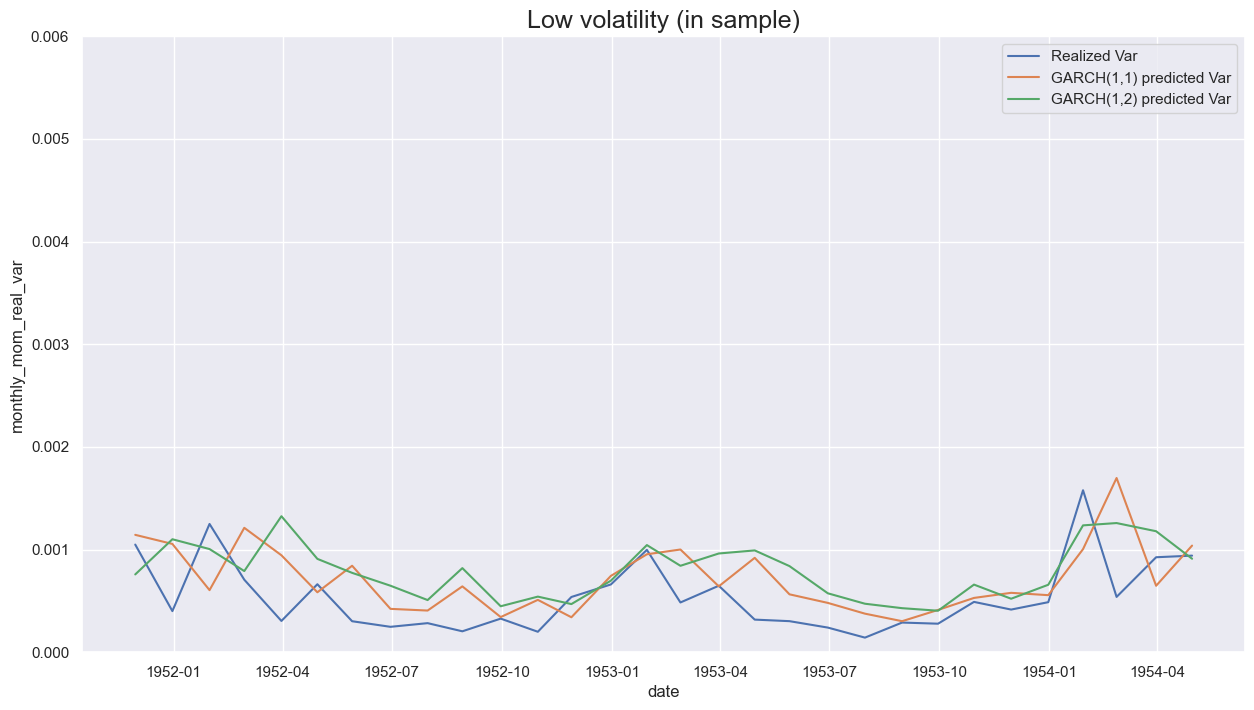

In [37]:
idx1 = 300
idx2 = 330
sns.lineplot(data = df.set_index('date').monthly_mom_real_var.iloc[idx1:idx2],label = 'Realized Var')
sns.lineplot(data = df.set_index('date').var_pred_garch11.iloc[idx1:idx2],label = 'GARCH(1,1) predicted Var')
sns.lineplot(data = df.set_index('date').var_pred_garch12.iloc[idx1:idx2],label = 'GARCH(1,2) predicted Var')
plt.legend()
plt.ylim([0,0.006])
plt.title('Low volatility (in sample)',size=18)
plt.show()

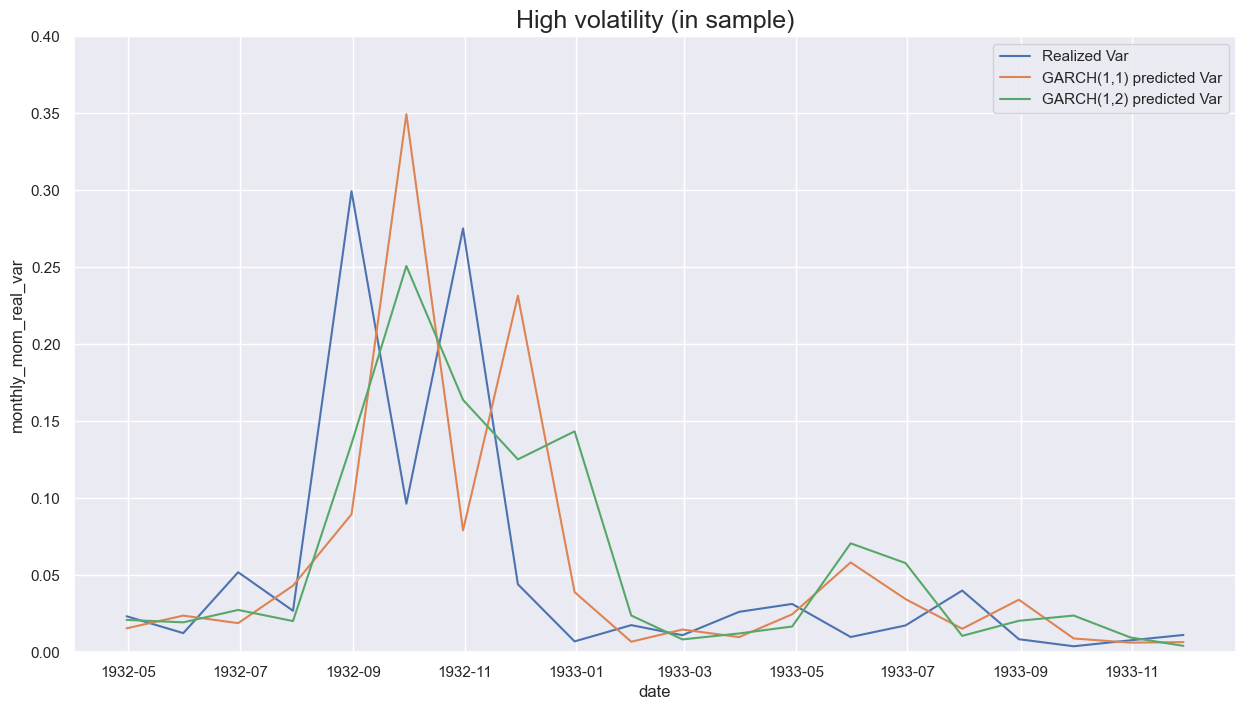

In [38]:

sns.lineplot(data = df.set_index('date').monthly_mom_real_var.iloc[75:95],label = 'Realized Var')
sns.lineplot(data = df.set_index('date').var_pred_garch11.iloc[75:95],label = 'GARCH(1,1) predicted Var')
sns.lineplot(data = df.set_index('date').var_pred_garch12.iloc[75:95],label = 'GARCH(1,2) predicted Var')
plt.legend()
plt.ylim([0,0.4])
plt.title('High volatility (in sample)',size=18)
plt.show()

In [39]:
df1 = df[(df.date<'2014-01-01')].copy()

In [40]:
# Regress realized variance on GARCH(1,1) and past 126 days realized variance
idx = max(df1['mom_var_126_M'].first_valid_index(),df1.monthly_mom_real_var[df1.monthly_mom_real_var>0].index[1])
reg_var11 = sm.OLS(endog=df1['monthly_mom_real_var'].iloc[idx:],exog=df1[['const','var_pred_garch11','mom_var_126_M']].iloc[idx:])

In [41]:
reg_var11.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     monthly_mom_real_var   R-squared:                       0.318
Model:                              OLS   Adj. R-squared:                  0.316
Method:                   Least Squares   F-statistic:                     239.2
Date:                  Sun, 11 Jun 2023   Prob (F-statistic):           5.15e-86
Time:                          21:04:54   Log-Likelihood:                 3007.1
No. Observations:                  1031   AIC:                            -6008.
Df Residuals:                      1028   BIC:                            -5993.
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0013      0.000      2.890      0.004       0.000       0.002
var_pred_garch11     0.3727      0.032     11.600      0.000       0.310       0.436
mom_var_126_M        0.3365      0.049      6.858      0.000       0.240       0.433
==============================================================================
Omnibus:                     1861.402   Durbin-Watson:                   2.381
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2137312.021
Skew:                          12.249   Prob(JB):                         0.00
Kurtosis:                     224.705   Cond. No.                         133.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
reg_var_params11 = reg_var11.fit().params

In [43]:
df['pred_variance11']=reg_var_params11[0] + reg_var_params11[1] * df['var_pred_garch11'] + reg_var_params11[2] * df['mom_var_126_M']

### Aparch model estimation

In [45]:
aparch = arch_model(df1['mom_ret'].loc[df1['mom_ret'][df1['mom_ret'] != 0].index[0:]]
,p=1,q=1,o=1,vol='aparch',rescale=False)

aparch_params = aparch.fit(disp=False).params
aparch.fit(disp=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - APARCH Model Results                     
==============================================================================
Dep. Variable:                mom_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     APARCH   Log-Likelihood:                1318.61
Distribution:                  Normal   AIC:                          -2625.23
Method:            Maximum Likelihood   BIC:                          -2595.59
                                        No. Observations:                 1032
Date:                Sun, Jun 11 2023   Df Residuals:                     1031
Time:                        21:04:55   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0170  1.807e-03      9.395  5.725e-21 [1.344e-02,2.052e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      6.2077e-04  1.136e-03      0.546      0.585 [-1.606e-03,2.847e-03]
alpha[1]       0.1604  6.017e-02      2.665  7.701e-03    [4.242e-02,  0.278]
gamma[1]      -0.5607      0.173     -3.248  1.162e-03      [ -0.899, -0.222]
beta[1]        0.8396  7.296e-02     11.509  1.190e-30      [  0.697,  0.983]
delta          1.4839      0.656      2.263  2.366e-02      [  0.198,  2.769]
=============================================================================

Covariance estimator: robust
"""

In [46]:
aparch121 = arch_model(df1['mom_ret'].loc[df1['mom_ret'][df1['mom_ret'] != 0].index[0:]]
,p=1,q=2,o=1,vol='aparch',rescale=False)

aparch_params121= aparch121.fit(disp=False).params
aparch121.fit(disp=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - APARCH Model Results                     
==============================================================================
Dep. Variable:                mom_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     APARCH   Log-Likelihood:                1324.08
Distribution:                  Normal   AIC:                          -2634.16
Method:            Maximum Likelihood   BIC:                          -2599.59
                                        No. Observations:                 1032
Date:                Sun, Jun 11 2023   Df Residuals:                     1031
Time:                        21:04:56   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0169  1.819e-03      9.281  1.686e-20 [1.331e-02,2.044e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      8.0827e-04  1.340e-03      0.603      0.546 [-1.818e-03,3.434e-03]
alpha[1]       0.2435  7.630e-02      3.192  1.415e-03    [9.398e-02,  0.393]
gamma[1]      -0.4904      0.127     -3.847  1.194e-04      [ -0.740, -0.241]
beta[1]        0.3462      0.139      2.493  1.267e-02    [7.401e-02,  0.618]
beta[2]        0.4102      0.111      3.699  2.168e-04      [  0.193,  0.628]
delta          1.5334      0.686      2.236  2.536e-02      [  0.189,  2.878]
=============================================================================

Covariance estimator: robust
"""

Variance forecast using aparch

In [47]:
df['var_pred_aparch'] = (aparch_params[1] + aparch_params[2]*(abs(df['mom_ret'].shift(1)-aparch_params[0]) - aparch_params[3]*df['mom_ret'].shift(1)-aparch_params[0])**aparch_params[5] + aparch_params[4] * df['monthly_mom_real_var'].shift(1)**(aparch_params[5]/2))**(2/aparch_params[5])
df['var_pred_aparch121'] = (aparch_params121[1] + aparch_params121[2]*(abs(df['mom_ret'].shift(1)-aparch_params121[0]) - aparch_params121[3]*df['mom_ret'].shift(1)-aparch_params121[0])**aparch_params121[6] + aparch_params121[4] * df['monthly_mom_real_var'].shift(1)**(aparch_params121[6]/2) + aparch_params121[5] * df['monthly_mom_real_var'].shift(2)**(aparch_params121[6]/2))**(2/aparch_params121[6])

In [48]:
df1 = df[(df.date<'2014-01-01')].copy()

In [49]:
first_idx = max(df1['var_pred_aparch'].first_valid_index(),df1['mom_var_126_M'].first_valid_index(),df1.monthly_mom_real_var[df1.monthly_mom_real_var>0].index[0])
idx_list = df1['var_pred_aparch'].dropna().index
reg_var_aparch = sm.OLS(endog=df1['monthly_mom_real_var'].iloc[idx_list].loc[first_idx:],exog=df1[['const','var_pred_aparch','mom_var_126_M']].iloc[idx_list].loc[first_idx:])
reg_var_ap_params = reg_var_aparch.fit().params

In [50]:
reg_var_aparch.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     monthly_mom_real_var   R-squared:                       0.269
Model:                              OLS   Adj. R-squared:                  0.267
Method:                   Least Squares   F-statistic:                     156.9
Date:                  Sun, 11 Jun 2023   Prob (F-statistic):           8.89e-59
Time:                          21:04:56   Log-Likelihood:                 2542.1
No. Observations:                   858   AIC:                            -5078.
Df Residuals:                       855   BIC:                            -5064.
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0021      0.000      4.333      0.000       0.001       0.003
var_pred_aparch     0.3831      0.038     10.196      0.000       0.309       0.457
mom_var_126_M       0.2053      0.050      4.112      0.000       0.107       0.303
==============================================================================
Omnibus:                     1689.973   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3273527.321
Skew:                          14.372   Prob(JB):                         0.00
Kurtosis:                     304.232   Cond. No.                         134.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
# Add APARCH predictions to dataframe
df['pred_variance_ap'] = reg_var_ap_params[0] + reg_var_ap_params[1]*df['var_pred_aparch'] + reg_var_ap_params[2]*df['mom_var_126_M']

#### RNN

In [53]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

In [54]:
#setting train and test funcion

def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}"].values
    test = dataset.loc[f"{tend+1}":].values
    return train, test

In [55]:
#setting train and test

tstart = 1926
tend = 2013
dataset = df[['date','monthly_mom_real_var']].set_index('date')

training_set, test_set = train_test_split(dataset, tstart, tend)
training_set_scaled = training_set

In [56]:
# Every monthly momentum variance is predicted using the last 12 monthly variance

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [57]:
n_steps = 12
features = 1
# Split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))

# Add a Dense layer 
model_lstm.add(Dense(units=1))

# Model compilation
model_lstm.compile(optimizer="RMSprop", loss="mse")

# Model summary
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               63500     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 63,626
Trainable params: 63,626
Non-trainable params: 0
_________________________________________________________________


In [58]:
model_lstm.fit(X_train, y_train, epochs=150, batch_size=32)
dataset_total = dataset
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values

Epoch 1/150
33/33 [==============================] - 2s 8ms/step - loss: 3.1531e-04
Epoch 2/150
33/33 [==============================] - 0s 7ms/step - loss: 2.8870e-04
Epoch 3/150
33/33 [==============================] - 0s 8ms/step - loss: 2.5774e-04
Epoch 4/150
33/33 [==============================] - 0s 8ms/step - loss: 2.8225e-04
Epoch 5/150
33/33 [==============================] - 0s 8ms/step - loss: 2.7001e-04
Epoch 6/150
33/33 [==============================] - 0s 8ms/step - loss: 2.6034e-04
Epoch 7/150
33/33 [==============================] - 0s 8ms/step - loss: 2.6750e-04
Epoch 8/150
33/33 [==============================] - 0s 8ms/step - loss: 2.6257e-04
Epoch 9/150
33/33 [==============================] - 0s 9ms/step - loss: 2.5170e-04
Epoch 10/150
33/33 [==============================] - 0s 8ms/step - loss: 2.3579e-04
Epoch 11/150
33/33 [==============================] - 0s 8ms/step - loss: 2.4880e-04
Epoch 12/150
33/33 [==============================] - 0s 8ms/step - loss: 

In [59]:
# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)

# Prediction
rnn_predicted_variance = model_lstm.predict(X_train)
rnn_predicted_variance = np.append(rnn_predicted_variance,model_lstm.predict(X_test))


4/4 [==============================] - 0s 5ms/step


In [60]:
df['var_pred_rnn'] = np.append(np.zeros(12),rnn_predicted_variance)

In [61]:
def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is ", rmse)

Compute lambdas s.t. momentum variance is 19%

In [62]:
df1 = df[df.date<'2014-01-01'].copy()

lbda11 = (df1['mu']*df1['mom_ret']/(df1['pred_variance11'])).std()/(2*0.19/np.sqrt(12))
lbda11_no_lin_reg = (df1['mu']*df1['mom_ret']/(df1['var_pred_garch11'])).std()/(2*0.19/np.sqrt(12))
lbda12 = (df1['mu']*df1['mom_ret']/(df1['var_pred_garch12'])).std()/(2*0.19/np.sqrt(12))
lbda_ap = (df1['mu']*df1['mom_ret']/(df1['pred_variance_ap'])).std()/(2*0.19/np.sqrt(12))
lbda_ap121 = (df1['mu']*df1['mom_ret']/(df1['var_pred_aparch121'])).std()/(2*0.19/np.sqrt(12))
lbda_rnn = (df1['mu']*df1['mom_ret']/(df1['var_pred_rnn'])).std()/(2*0.19/np.sqrt(12))

Compute dynamic optimal weights and cumulative returns for each strategy 

In [63]:
df['w_dyn11'] = df['mu']/(2*lbda11*df['pred_variance11'])
df['w_dyn11_no_lin_reg'] = df['mu']/(2*lbda11_no_lin_reg*df['var_pred_garch11'])
df['w_dyn12'] = df['mu']/(2*lbda12*df['var_pred_garch12'])
df['w_dyn_ap'] = df['mu']/(2*lbda_ap*df['pred_variance_ap'])
df['w_dyn_ap121'] = df['mu']/(2*lbda_ap121*df['var_pred_aparch121'])
df['w_dyn_rnn'] = df['mu']/(2*lbda_rnn*df['var_pred_rnn'])


df['mom_ret_dyn11'] = df['w_dyn11']*df['mom_ret']
df['mom_ret_dyn11_no_lin_reg'] = df['w_dyn11_no_lin_reg']*df['mom_ret']
df['mom_ret_dyn12'] = df['w_dyn12']*df['mom_ret']
df['mom_ret_dyn_ap'] = df['w_dyn_ap']*df['mom_ret']
df['mom_ret_dyn_ap121'] = df['w_dyn_ap121']*df['mom_ret']
df['mom_ret_dyn_rnn'] = df['w_dyn_rnn']*df['mom_ret']

df['cum_ret11'] = (df['mom_ret_dyn11'] + df['rf'] + 1).cumprod()
df['cum_ret11_no_lin_reg'] = (df['mom_ret_dyn11_no_lin_reg'] + df['rf'] + 1).cumprod()
df['cum_ret12'] = (df['mom_ret_dyn12'] + df['rf'] + 1).cumprod()
df['cum_ret_ap'] = (df['mom_ret_dyn_ap'] + df['rf'] + 1).cumprod()
df['cum_ret_ap121'] = (df['mom_ret_dyn_ap121'] + df['rf'] + 1).cumprod()
df['cum_ret_rnn'] = (df['mom_ret_dyn_rnn'] + df['rf'] + 1).cumprod()

In-sample weights comparison (GARCH(1,1) vs RNN)

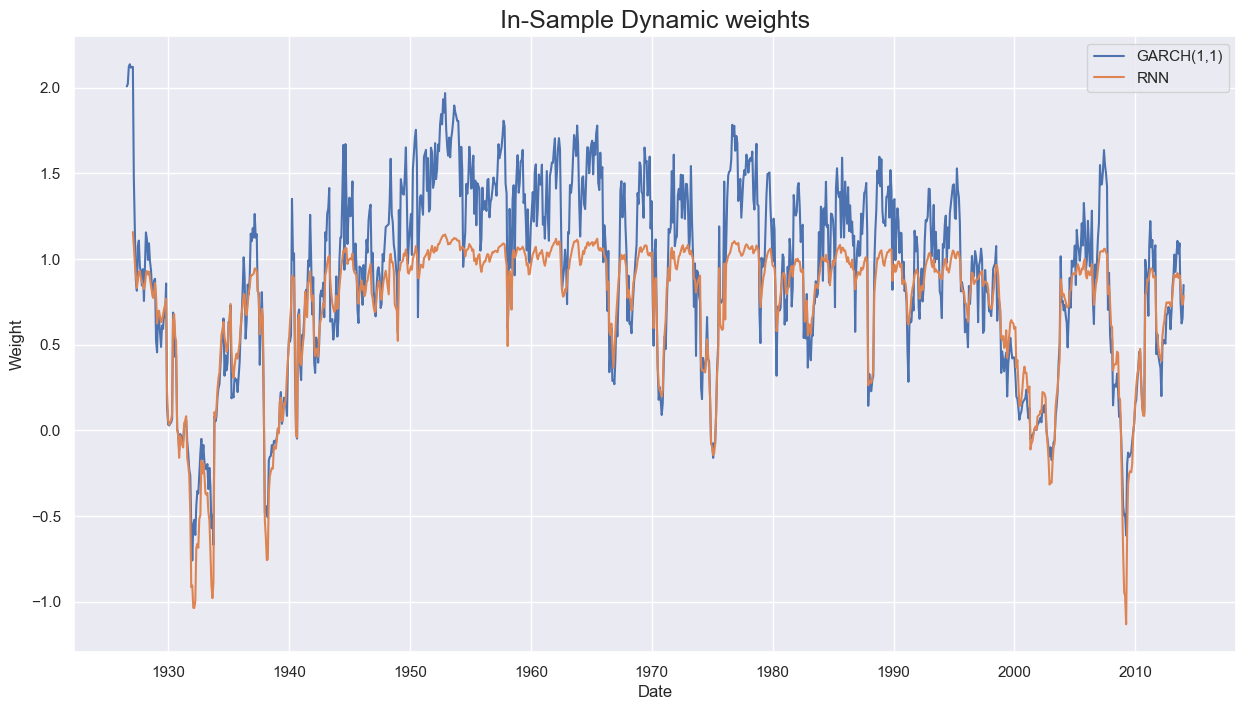

In [64]:
df1 = df[df.date<'2014-01-01'].copy()
sns.lineplot(data=df1.set_index('date')['w_dyn11'],label = 'GARCH(1,1)')
sns.lineplot(data=df1.set_index('date')['w_dyn_rnn'],label = 'RNN')
plt.ylabel('Weight')
plt.xlabel('Date')
plt.title('In-Sample Dynamic weights',size = 18)
plt.show()

Out-of-sample weights comparison (GARCH(1,1) vs RNN)

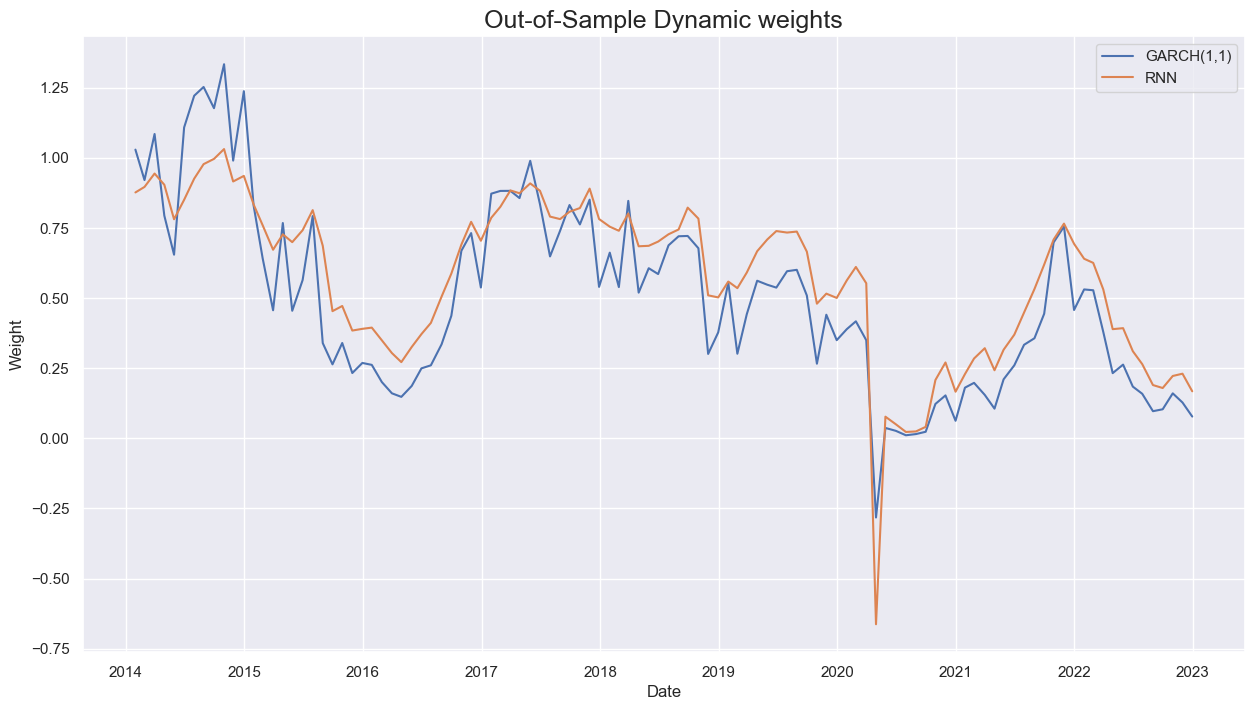

In [65]:
df2 = df[df.date>='2014-01-01'].copy()
sns.lineplot(data=df2.set_index('date')['w_dyn11'],label = 'GARCH(1,1)')
sns.lineplot(data=df2.set_index('date')['w_dyn_rnn'],label = 'RNN')
plt.ylabel('Weight')
plt.xlabel('Date')
plt.title('Out-of-Sample Dynamic weights',size = 18)
plt.show()

In-sample performances (normalizing for 19% annual variance)

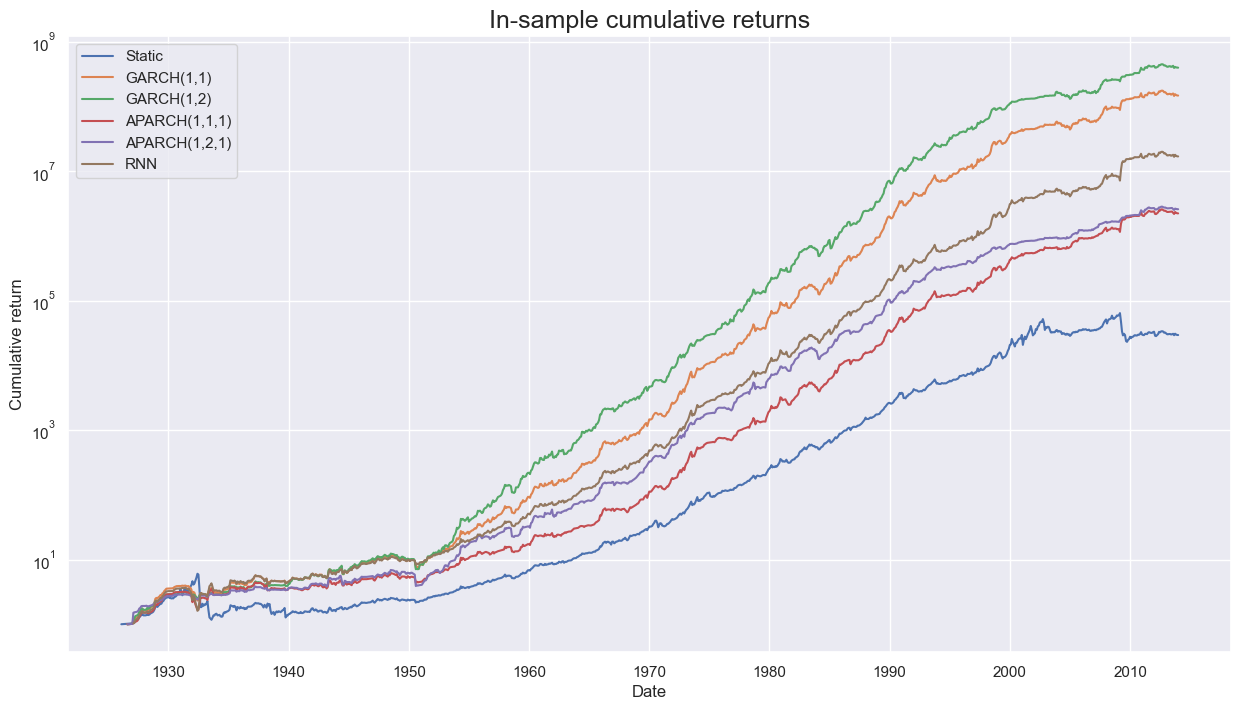

In [66]:
w_static = 0.19 / (np.sqrt(12)*mom_ret.std())
sns.lineplot(data=(w_static*df1.set_index('date')['mom_ret'] + Rf.set_index('date').rf + 1).cumprod(),label = 'Static')
sns.lineplot(data = df1.set_index('date')['cum_ret11'],label='GARCH(1,1)')
sns.lineplot(data = df1.set_index('date')['cum_ret12'],label='GARCH(1,2)')

sns.lineplot(data = df1.set_index('date')['cum_ret_ap'],label='APARCH(1,1,1)')
sns.lineplot(data = df1.set_index('date')['cum_ret_ap121'],label='APARCH(1,2,1)')
sns.lineplot(data = df1.set_index('date')['cum_ret_rnn'],label='RNN')

plt.title('In-sample cumulative returns',size = 18)
plt.yscale(value='log')
plt.ylabel('Cumulative return')
plt.xlabel('Date')
plt.show()

In-sample Sharpe Ratios 

In [67]:
df1 = df[df['date']<'2014-01-01']
SR11=(df1['mom_ret_dyn11'].mean()*12 - Rf.rf.mean())/(np.sqrt(12)*df1['mom_ret_dyn11'].std())
SR11_no_lin_reg=(df1['mom_ret_dyn11_no_lin_reg'].mean()*12 - Rf.rf.mean())/(np.sqrt(12)*df1['mom_ret_dyn11_no_lin_reg'].std())

SR12=(df1['mom_ret_dyn12'].mean()*12 - Rf.rf.mean())/(np.sqrt(12)*df1['mom_ret_dyn12'].std())

SR_ap=(df1['mom_ret_dyn_ap'].mean()*12 - Rf.rf.mean())/(np.sqrt(12)*df1['mom_ret_dyn_ap'].std())
SR_ap121=(df1['mom_ret_dyn_ap121'].mean()*12 - Rf.rf.mean())/(np.sqrt(12)*df1['mom_ret_dyn_ap121'].std())
SR_rnn = (df1['mom_ret_dyn_rnn'].mean()*12 - Rf.rf.mean())/(np.sqrt(12)*df1['mom_ret_dyn_rnn'].std())

print('Sharpe ratios in sample \n GARCH(1,1): {} \n GARCH(1,1) no linear regression: {}\n GARCH(1,2): {} \n APARCH(1,1,1): {} \n APARCH(1,2,1): {} \n RNN: {}'.format(SR11,SR11_no_lin_reg,SR12,SR_ap,SR_ap121,SR_rnn))

Sharpe ratios in sample 
 GARCH(1,1): 1.0559590854346663 
 GARCH(1,1) no linear regression: 1.0627748655076512
 GARCH(1,2): 1.1168675731992834 
 APARCH(1,1,1): 0.9768207651448141 
 APARCH(1,2,1): 1.0010386748608882 
 RNN: 0.9258175166129736


In-sample MSE

In [76]:
mse11_IS = ((df1['monthly_mom_real_var']-df1['pred_variance11'])**2).mean()
mse11_no_lin_reg_IS = ((df1['monthly_mom_real_var']-df1['var_pred_garch11'])**2).mean()
mse12_IS = ((df1['monthly_mom_real_var']-df1['var_pred_garch12'])**2).mean()
mse_ap_IS = ((df1['monthly_mom_real_var']-df1['pred_variance_ap'])**2).mean()
mse_ap121_IS = ((df1['monthly_mom_real_var']-df1['var_pred_aparch121'])**2).mean()
mse_rnn_IS = ((df1['monthly_mom_real_var']-df1['var_pred_rnn'])**2).mean()

print('MSE in sample: \n GARCH(1,1): {} \n GARCH(1,1) no lin reg: {}\n GARCH(1,2): {} \n APARCH(1,1,1): {} \n APARCH(1,2,1): {} \n RNN: {}'.format(mse11_IS,mse11_no_lin_reg_IS,mse12_IS,mse_ap_IS,mse_ap121_IS,mse_rnn_IS))

MSE in sample: 
 GARCH(1,1): 0.0001703098789976847 
 GARCH(1,1) no lin reg: 0.00024138176983407709
 GARCH(1,2): 0.00016402739210929137 
 APARCH(1,1,1): 0.00015528430123418335 
 APARCH(1,2,1): 0.00016230953594927294 
 RNN: 0.00018839108855197542


In-sample volatility forecasting

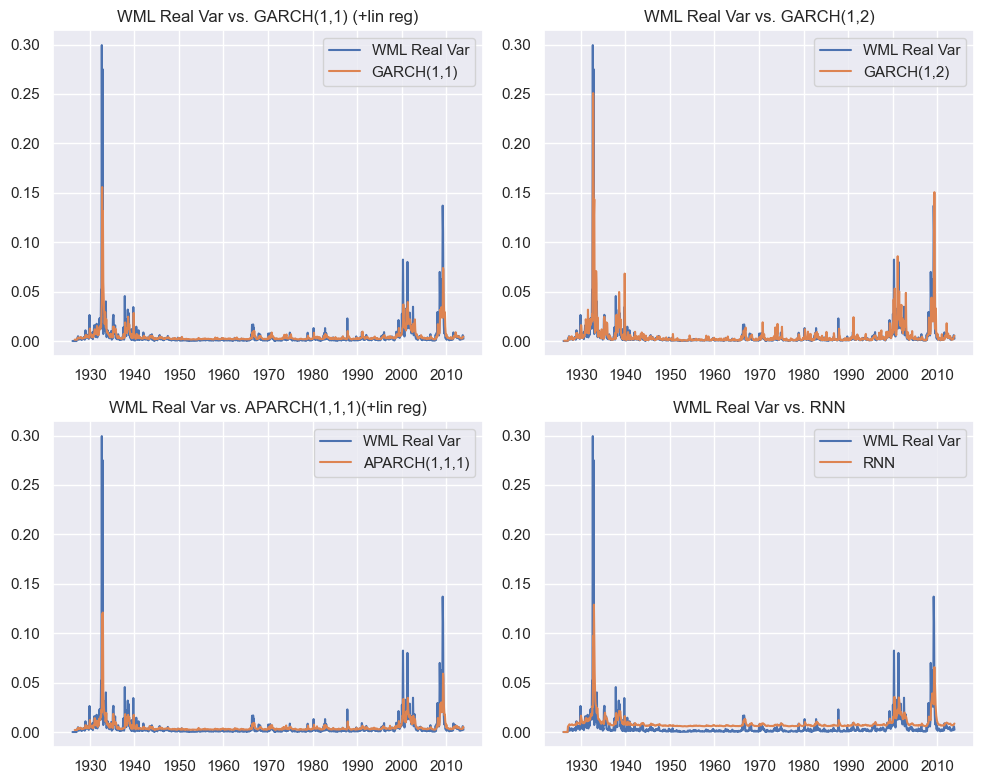

In [69]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

idx1 = 0
idx2 = -1

axs[0, 0].plot(df1.set_index('date').iloc[idx1:idx2]['monthly_mom_real_var'], label='WML Real Var')
axs[0, 0].plot(df1.set_index('date').iloc[idx1:idx2]['pred_variance11'], label='GARCH(1,1)')
axs[0, 0].set_title('WML Real Var vs. GARCH(1,1) (+lin reg)')
axs[0, 0].legend()

axs[0, 1].plot(df1.iloc[idx1:idx2].set_index('date')['monthly_mom_real_var'], label='WML Real Var')
axs[0, 1].plot(df1.iloc[idx1:idx2].set_index('date')['var_pred_garch12'], label='GARCH(1,2)')
axs[0, 1].set_title('WML Real Var vs. GARCH(1,2)')
axs[0, 1].legend()


axs[1, 0].plot(df1.iloc[idx1:idx2].set_index('date')['monthly_mom_real_var'], label='WML Real Var')
axs[1, 0].plot(df1.iloc[idx1:idx2].set_index('date')['pred_variance_ap'].interpolate(), label='APARCH(1,1,1)')
axs[1, 0].set_title('WML Real Var vs. APARCH(1,1,1)(+lin reg)')
axs[1, 0].legend()

axs[1, 1].plot(df1.iloc[idx1:idx2].set_index('date')['monthly_mom_real_var'], label='WML Real Var')
axs[1, 1].plot(df1.iloc[idx1:idx2].set_index('date')['var_pred_rnn'], label='RNN')
axs[1, 1].set_title('WML Real Var vs. RNN')
axs[1, 1].legend()


plt.tight_layout()

plt.show()


In-sample forecasting during high volatility period

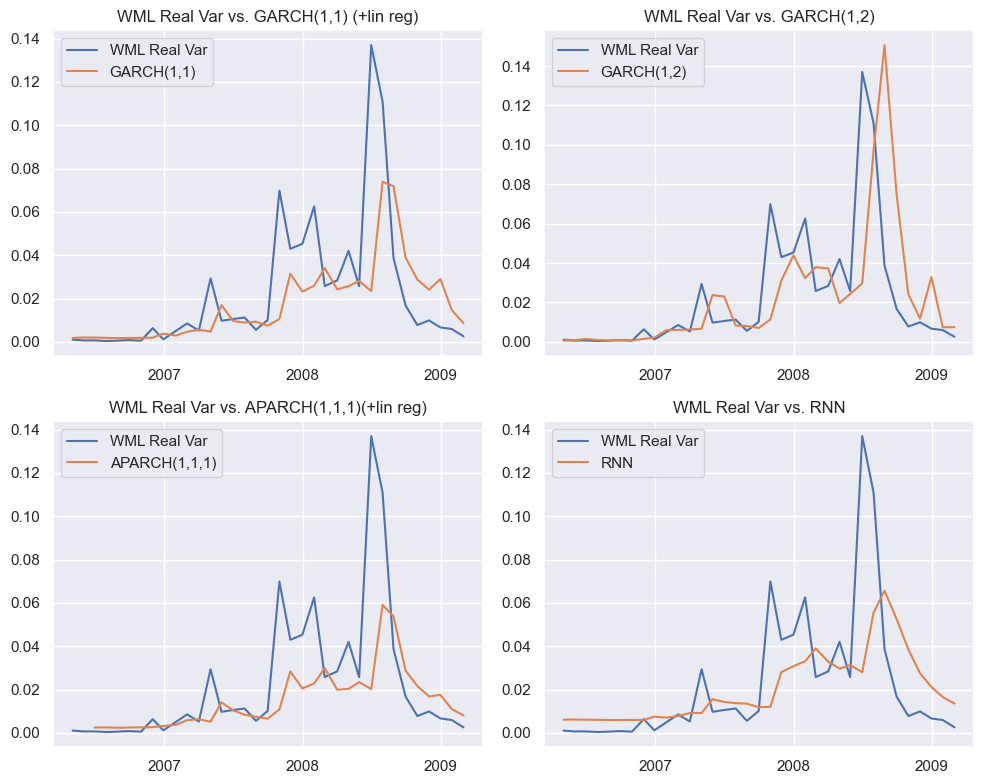

In [70]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

idx1 = 960
idx2 = 995

axs[0, 0].plot(df1.set_index('date').iloc[idx1:idx2]['monthly_mom_real_var'], label='WML Real Var')
axs[0, 0].plot(df1.set_index('date').iloc[idx1:idx2]['pred_variance11'], label='GARCH(1,1)')
axs[0, 0].set_title('WML Real Var vs. GARCH(1,1) (+lin reg)')
axs[0, 0].legend()

axs[0, 1].plot(df1.iloc[idx1:idx2].set_index('date')['monthly_mom_real_var'], label='WML Real Var')
axs[0, 1].plot(df1.iloc[idx1:idx2].set_index('date')['var_pred_garch12'], label='GARCH(1,2)')
axs[0, 1].set_title('WML Real Var vs. GARCH(1,2)')
axs[0, 1].legend()


axs[1, 0].plot(df1.iloc[idx1:idx2].set_index('date')['monthly_mom_real_var'], label='WML Real Var')
axs[1, 0].plot(df1.iloc[idx1:idx2].set_index('date')['pred_variance_ap'].interpolate(), label='APARCH(1,1,1)')
axs[1, 0].set_title('WML Real Var vs. APARCH(1,1,1)(+lin reg)')
axs[1, 0].legend()

axs[1, 1].plot(df1.iloc[idx1:idx2].set_index('date')['monthly_mom_real_var'], label='WML Real Var')
axs[1, 1].plot(df1.iloc[idx1:idx2].set_index('date')['var_pred_rnn'], label='RNN')
axs[1, 1].set_title('WML Real Var vs. RNN')
axs[1, 1].legend()

# Set the x-axis ticker locator and formatter
locator = mdates.MonthLocator(interval=12)
formatter = mdates.ConciseDateFormatter(locator)
for i in range(0,2):
    for j in range(0,2):
        axs[i, j].xaxis.set_major_locator(locator)
        axs[i, j].xaxis.set_major_formatter(formatter)

plt.tight_layout()

plt.show()


### Out of sample prediction and investment (2014-2022)

Out-of-sample volatility forecasting

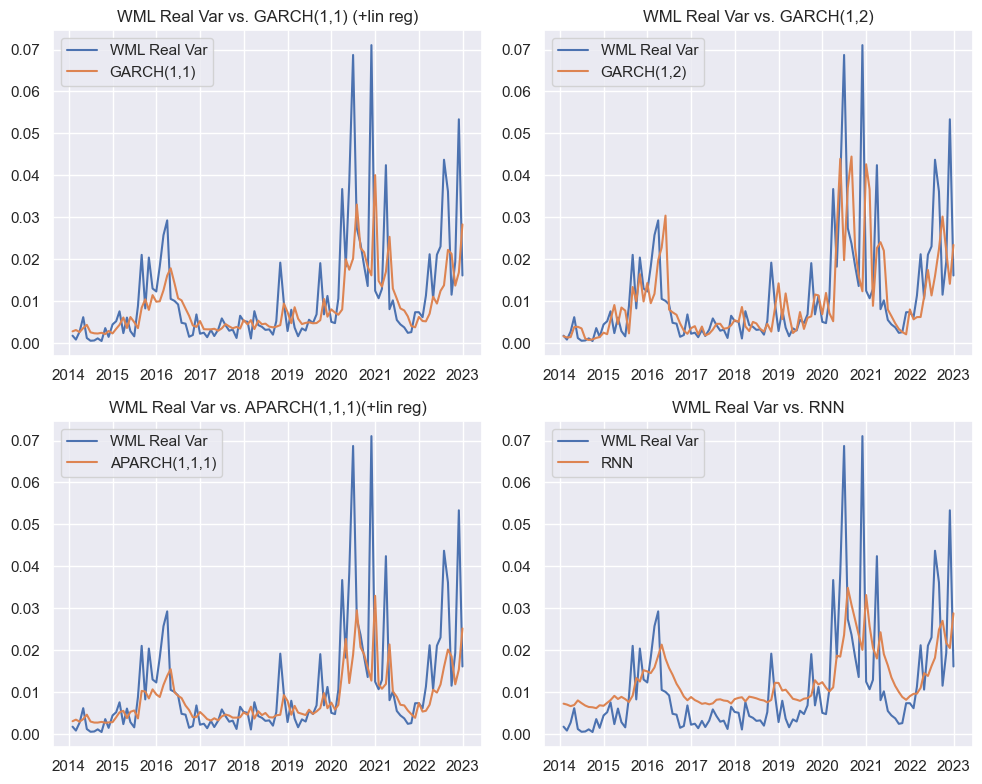

In [71]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(df2.set_index('date')['monthly_mom_real_var'], label='WML Real Var')
axs[0, 0].plot(df2.set_index('date')['pred_variance11'], label='GARCH(1,1)')
axs[0, 0].set_title('WML Real Var vs. GARCH(1,1) (+lin reg)')
axs[0, 0].legend()

axs[0, 1].plot(df2.set_index('date')['monthly_mom_real_var'], label='WML Real Var')
axs[0, 1].plot(df2.set_index('date')['var_pred_garch12'], label='GARCH(1,2)')
axs[0, 1].set_title('WML Real Var vs. GARCH(1,2)')
axs[0, 1].legend()

axs[1, 0].plot(df2.set_index('date')['monthly_mom_real_var'], label='WML Real Var')
axs[1, 0].plot(df2.set_index('date')['pred_variance_ap'].interpolate(), label='APARCH(1,1,1)')
axs[1, 0].set_title('WML Real Var vs. APARCH(1,1,1)(+lin reg)')
axs[1, 0].legend()

axs[1, 1].plot(df2.set_index('date')['monthly_mom_real_var'], label='WML Real Var')
axs[1, 1].plot(df2.set_index('date')['var_pred_rnn'], label='RNN')
axs[1, 1].set_title('WML Real Var vs. RNN')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


Out-of-sample cumulative returns

In [72]:
df2['mom_ret_cum'] = (df2['mom_ret'] + df2['rf'] + 1).cumprod()
df2['cum_ret11'] = (df2['mom_ret_dyn11'] + df2['rf'] + 1).cumprod()
df2['cum_ret11_no_lin_reg'] = (df2['mom_ret_dyn11_no_lin_reg'] + df2['rf'] + 1).cumprod()
df2['cum_ret12'] = (df2['mom_ret_dyn12'] + df2['rf'] + 1).cumprod()
df2['cum_ret_ap'] = (df2['mom_ret_dyn_ap'] + df2['rf'] + 1).cumprod()
df2['cum_ret_ap121'] = (df2['mom_ret_dyn_ap121'] + df2['rf'] + 1).cumprod()
df2['cum_ret_rnn'] = (df2['mom_ret_dyn_rnn'] + df2['rf'] + 1).cumprod()

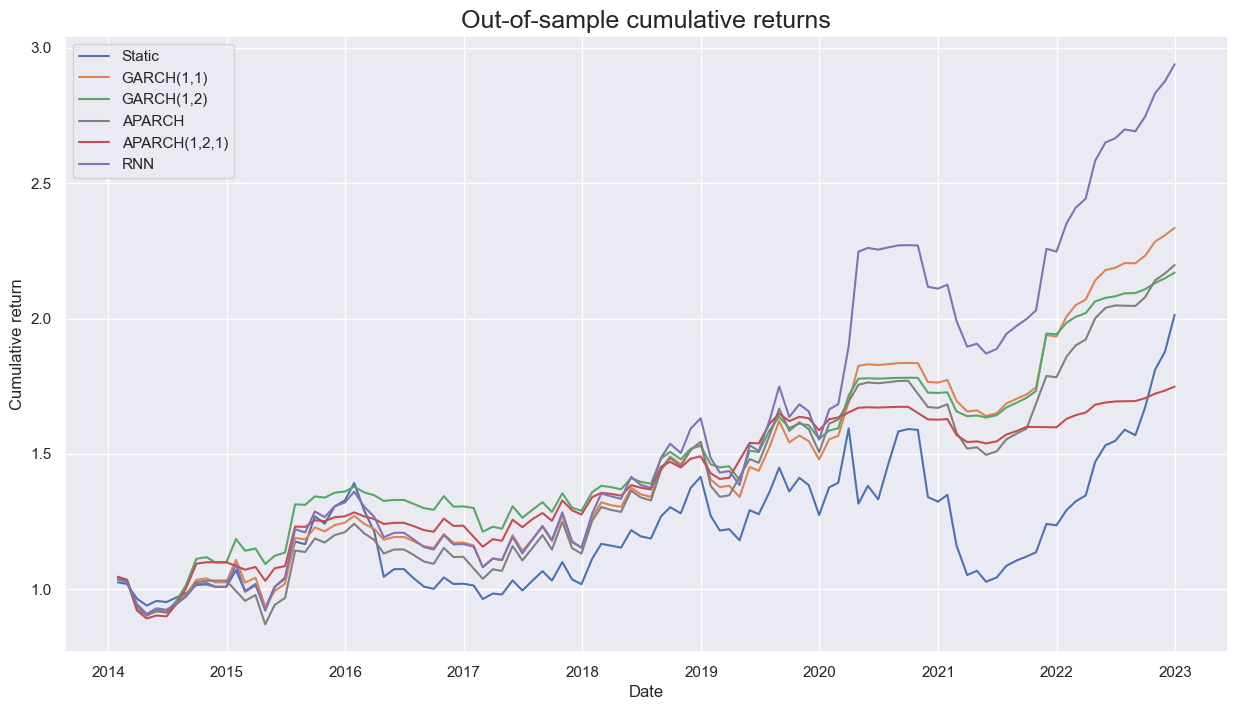

In [73]:
w_static = 0.19 / (np.sqrt(12)*mom_ret.std())
sns.lineplot(data=(w_static*df2.set_index('date')['mom_ret'] + Rf.set_index('date').rf + 1).cumprod(),label = 'Static')
sns.lineplot(data = df2.set_index('date')['cum_ret11'],label='GARCH(1,1)')
sns.lineplot(data = df2.set_index('date')['cum_ret12'],label='GARCH(1,2)')

sns.lineplot(data = df2.set_index('date')['cum_ret_ap'],label='APARCH',color='grey')
sns.lineplot(data = df2.set_index('date')['cum_ret_ap121'],label='APARCH(1,2,1)')
sns.lineplot(data = df2.set_index('date')['cum_ret_rnn'],label='RNN')

plt.title('Out-of-sample cumulative returns',size = 18)
plt.ylabel('Cumulative return')
plt.xlabel('Date')
plt.show()

Out-of-sample Sharpe Ratios

In [74]:
SR11_new=(df2['mom_ret_dyn11'].mean()*12 - Rf.rf.mean())/(np.sqrt(12)*df2['mom_ret_dyn11'].std())
SR11_no_lin_reg_new=(df2['mom_ret_dyn11_no_lin_reg'].mean()*12 - Rf.rf.mean())/(np.sqrt(12)*df2['mom_ret_dyn11_no_lin_reg'].std())

SR12_new=(df2['mom_ret_dyn12'].mean()*12 - Rf.rf.mean())/(np.sqrt(12)*df2['mom_ret_dyn12'].std())

SR_ap_new=(df2['mom_ret_dyn_ap'].mean()*12 - Rf.rf.mean())/(np.sqrt(12)*df2['mom_ret_dyn_ap'].std())
SR_ap121_new=(df2['mom_ret_dyn_ap121'].mean()*12 - Rf.rf.mean())/(np.sqrt(12)*df2['mom_ret_dyn_ap121'].std())
SR_rnn = (df2['mom_ret_dyn_rnn'].mean()*12 - Rf.rf.mean())/(np.sqrt(12)*df2['mom_ret_dyn_rnn'].std())

print('Sharpe ratios out of sample \n GARCH(1,1): {} \n GARCH(1,1) no lin reg: {}\n GARCH(1,2): {} \n APARCH(1,1,1): {} \n APARCH(1,2,1): {}\n RNN: {}'.format(SR11_new,SR11_no_lin_reg_new,SR12_new,SR_ap_new,SR_ap121_new,SR_rnn))

Sharpe ratios out of sample 
 GARCH(1,1): 0.6422518845665841 
 GARCH(1,1) no lin reg: 0.4725612603701121
 GARCH(1,2): 0.6829274234133385 
 APARCH(1,1,1): 0.594561124616633 
 APARCH(1,2,1): 0.5812881727992305
 RNN: 0.7061746183485218


Out-of-sample MSE

In [75]:
mse11 = ((df2['monthly_mom_real_var']-df2['pred_variance11'])**2).mean()
mse11_no_lin_reg = ((df2['monthly_mom_real_var']-df2['var_pred_garch11'])**2).mean()
mse12 = ((df2['monthly_mom_real_var']-df2['var_pred_garch12'])**2).mean()
mse_ap = ((df2['monthly_mom_real_var']-df2['pred_variance_ap'])**2).mean()
mse_ap121 = ((df2['monthly_mom_real_var']-df2['var_pred_aparch121'])**2).mean()
mse_rnn = ((df2['monthly_mom_real_var']-df2['var_pred_rnn'])**2).mean()


print('MSE out of sample \n GARCH(1,1): {} \n GARCH(1,1) no lin reg: {}\n GARCH(1,2): {} \n APARCH(1,1,1): {} \n APARCH(1,2,1): {} \n RNN: {}'.format(mse11,mse11_no_lin_reg,mse12,mse_ap,mse_ap121,mse_rnn))

MSE out of sample 
 GARCH(1,1): 0.0001237046254476456 
 GARCH(1,1) no lin reg: 0.00015870419036756716
 GARCH(1,2): 0.00014200025493327337 
 APARCH(1,1,1): 0.00012113622706485211 
 APARCH(1,2,1): 0.0001265986187919722 
 RNN: 0.00012059921201495666
